In [1]:
#

In [3]:
import numpy as np
import os.path
import csv

import data_tools as dt

import matplotlib.pyplot as plt
%matplotlib inline

## Quick Look at the Data

Firstly import the data, in CSV format, with the python csv reader and convert to proper data formats.

In [4]:
filepath = 'data/task/task1.csv'
csv_raw = []
with open(filepath) as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        if not row or i == 0:
            continue
        idx = int(row[0])
        x = float(row[1])
        y = float(row[2])
        target = int(float(row[3]))
        csv_raw.append([idx, x, y, target])

In [5]:
print('Task dataset has {} entries.'.format(len(csv_raw)))

Task dataset has 15000 entries.


### Data Distribution

Taking a quick look at what kind of data we have. Below there is a scatter plot, for the X and Y values given. The target has been shown with colour.

It looks like there's considerable overlap in the data, so with only two features, these targets will not be perfectly separable. It seems like a linear model could do a fairly good job at separating these targets, so perhaps a Neural Network is not even necessary. However, you could get increased accuracy by separating with a Neural Net.

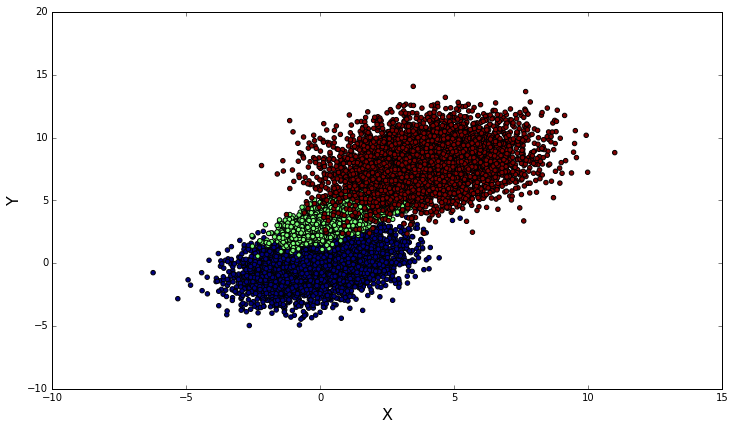

In [6]:
idx, x, y, target = zip(*csv_raw)
fig, ax = plt.subplots(figsize=(12,6.75))
ax.scatter(x, y, c=target)
ax.set_ylabel('Y', fontsize=16)
ax.set_xlabel('X', fontsize=16)

## Import and Process Dataset

The import and pre-processing of the dataset will be handled by a DataManager tool I made earlier. Basically it reads in the raw CSV, splits into train/valid/test datasets with even distributions of each class, then one-hot encodes the output classes.

In [10]:
filepath = 'data/task/task1.csv'
data_manager = dt.TaskData(filepath, (0.8,0.10,0.10))
data_manager.init_dataset()
X, Y = data_manager.prepare_train()
X_valid, Y_valid = data_manager.prepare_valid()

Preparing Train/Valid/Test data from data/task/task1.csv
Split train has (4000, 4000, 4000) examples of each class
Split test has (500, 500, 500) examples of each class
Split valid has (500, 500, 500) examples of each class
Dataset prepared


## Neural Network Implementation

To implement a Neural Network from scratch, first prepare a basic NeuralNet class that will keep the whole network together. The constructor takes in the dimensions of the input and the learning rate: 

`NeuralNet(2, lr=1e-1)`

Here the inputs are two coordinate-like inputs, and the outputs are 3 classes. The learning rate of 1e-1 is fairly large, and can help the network get close to the minimum region quickly.

### Layers

This implementation considers each neural network operation as a layer. The NeuralNet object holds a list of all these layers, `self.layers`, and provides a method for adding new layers `add_layer()`. In order to initialise the layer weights, e.g. in a Fully-Conencted layer, the layer needs to be aware of the number of inputs (i.e. the number of outputs of the previous layer). So when you add a layer, the NeuralNet will ask for the number of hidden units (`n_hidden()`) of the previous layer. If it's the first layer, the number of inputs are used.

### Feeding

The neural network receives some inputs, processes them through its layers to get some outputs, and also receives some ground truth labels for training. The objective is to learn an arbitrary function that makes the predictions close to the ground truth labels. This process begins by feeding into the NeuralNet the inputs and labels with `NeuralNet.feed(inputs, labels)`.

### Forward Pass

This implementation takes a very modular approach, similar to Caffe, where each layer has a forward pass where it calculates it's output, and a backward pass where it propagates derivatives from the loss and calculates a weight update. The NeuralNet `forward()` method successively calls `forward()` on each layer, passing the output of the previous layer as the input to the next, until it reaches the last layer. Finally it calls `loss()` on itself to calculate the difference of the final output and the labels. In the current implementation, the actual probabilities and cost are calculated together using the output of the last layer.

### Backward Pass

The cost function will calculate a loss from the difference of the network output probabilities and the ground truth labels. It will also calculate the derivative of this loss w.r.t. the final layer outputs, and store it in `NeuralNet.del_loss`. The network will then call the `backward()` method of each layer, from top to bottom (last to first), firstly passing `del_loss` and then passing back the derivative w.r.t to the inputs of each layer. With this derivative, each layer can calculate how its weights affects the final loss of the network, and prepare an appropriate weight update.

### Loss (NeuralNet)

The total loss has two compoenents, one comes from Regularisation, and one from the Cost Function (these are discussed later). One form of regularisation penalises the network for having large weights, so this method firstly collects the weights from each layer and passes it to a `Regulariser` object. This object (L2 Regularisation in this implementation) will return the value to penalise the loss by.
Currently the loss contribution from the cost and from regularisation are handled independently.

In [11]:
class NeuralNet(object):
    def __init__(self, dim_inputs, lr=1e-1):
        self.n_layers = 0
        self.layers = []
        self.dim_inputs = dim_inputs
        self.final_output = None
        self.lr = lr

    def add_layer(self, layer):
        if self.n_layers == 0:
            n_in = self.dim_inputs
        else:
            n_in = self.layers[self.n_layers - 1].n_hidden()
        layer.init(n_in, self.lr, self.regulariser.lambda_parameter())
        self.layers.append(layer)
        self.n_layers += 1

    def feed(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    # Learning Rate
    def set_lr(self, lr):
        self.lr = lr

    def set_cost(self, cost_function):
        self.cost_function = cost_function

    def set_regulariser(self, regulariser):
        self.regulariser = regulariser

    def forward(self):
        for i, layer in enumerate(self.layers):
            if i == 0:
                layer.feed(self.inputs)
            else:
                layer.feed(step_output)
            step_output = layer.forward()
        self.final_output = step_output

        total_loss, prob = self.loss()
        self.prob = prob

        return self.prob, total_loss

    def backward(self):
        d_loss_input = self.del_loss
        for i, layer in reversed(list(enumerate(self.layers))):
            d_loss_input = layer.backward(d_loss_input)
        return d_loss_input

    def loss(self):
        # collect weights
        layer_weights = []
        for layer in self.layers:
            layer_weights.append(layer.layer_weights())
        reg_loss = self.regulariser.regularisation_loss(layer_weights)

        prob, entropy_loss, del_loss = self.cost_function.loss(self.final_output, self.labels)
        self.del_loss = del_loss

        self.total_loss = entropy_loss + reg_loss
        return self.total_loss, prob

    def set_test_mode(self):
        for layer in self.layers:
            layer.set_test_mode()

    def set_train_mode(self):
        for layer in self.layers:
            layer.set_train_mode()

Instantiating a NeuralNet object with 2 inputs and $1 \times 10^{-1}$ learning rate.

In [14]:
my_net = NeuralNet(2, lr=1e-1)

## Regularisation

In this implementation, L2 Regularisation is used. This object is inisialised with a `reg_lambda` (regularisation lambda), which is a parameter that affects how much the weights penalise the loss.
The job of this object is to take in a list of weights, then calculate a penalty to the loss with the `regularisation loss(weight_list)` method. The L2 Regularisation is defined as:

$$\delta {\rm loss} = \frac{1}{2} \lambda \sum_i (W_i^2)$$

Where this sum is carried out over every weight in the Neural Network.

In [12]:
class Regulariser(object):
    def __init__(self):
        pass

class L2Regulariser(Regulariser):
    def __init__(self, reg_lambda):
        self.reg_lambda = reg_lambda

    def lambda_parameter(self):
        return self.reg_lambda

    def regularisation_loss(self, weight_list):
        reg_loss = 0
        for weights in weight_list:
            reg_loss += 0.5 * self.reg_lambda * np.sum(weights*weights)
        return reg_loss

The regulariser can be added to the NeuralNet:

In [15]:
my_net.set_regulariser(L2Regulariser(1e-3))

## Softmax Cross-Entropy Loss

In the current implementation the Softmax function and Cross-Entropy Loss have been combined, as they have a simple expression for the derivative w.r.t the final outputs of the network. Firstly the Softmax of the final layer outputs is calculated, which converts them into proper probabilities. Softmax is defined as:

$${\rm Softmax}(Z)_i = \frac{e^{z_i} }{\sum_j^N e^{z_j} } = p_i \qquad \text{for } i=1,...,N$$

where $Z$ are the final layer outputs and $N$ is the number of classes. 

### Numerical Stability

Since we're taking exponentials, numerically this function can quickly become unstable. For this reason, all values are shifted by the maximum output, and the final output of the Softmax function is the same.
Similarly, in the cross-entropy cost function we take the $\log$ and $\log(0)$ is $-\infty$, so the probabilities have been clipped between a small value $\epsilon$ and $(1-\epsilon)$, where by default $\epsilon = 1 \times 10^{-8}$.

### Cross-Entropy Loss

The cross-entropy loss is commonly used in classification. It checks the output probability for the correct class (ground truth), and outputs a loss that is close to 0 as the probability tends to 1.0; and tends to $\infty$ as the probabilitiy tends to 0.0.

$$L = - Y \log (p)$$

where $L$ is the cross-entropy loss, $Y$ are the correct ground truth labels that are non-zero only for the correct class, and $p$ are the output probabilities for each class. This is the formulation used in this implementation, but there is also a version that pushes probabilties of the wrong class to 0.0 too.


### Derivative

The backward pass through the network begins with the derivative of the loss w.r.t. the final layer outputs. For the Softmax and Cross-Entropy functions, this expression simplifies to:

$$\frac{\partial L}{\partial z_i} = p_i - y_i $$

where $L$ is the loss, $z_i$ are the final layer outputs, $p_i$ are the probabilities, and $y_i$ are the labels that are equal to 1 for the correct label, and 0 for the others.
Finally, these probabilities are normalised by the number of examples in the batch (sums will be taken later).

In [16]:
class LossFunction(object):
    def __init__(self):
        pass

    def loss(self, final_output, labels):
        raise NotImplementedError

class SoftmaxCrossEntropyLoss(LossFunction):
    def __init__(self):
        pass

    def loss(self, final_output, labels, epsilon=1e-8):
        num_examples = final_output.shape[0]

        # shift output values for numerical stability
        shifted_output = final_output - np.max(final_output, axis=1, keepdims=True)

        exp_outputs = np.exp(shifted_output)
        probabilities = exp_outputs / np.sum(exp_outputs, axis=1, keepdims=True)

        # numerical stability, clip 0 probabilities
        safe_probs = np.clip(probabilities, epsilon, 1-epsilon)

        cross_entropy = -labels * np.log(safe_probs)

        d_prob = np.copy(probabilities)
        d_prob -= labels
        d_prob /= num_examples
        return probabilities, cross_entropy, d_prob

Add the `SoftmaxCrossEntropyLoss` to the NeuralNet:

In [17]:
my_net.set_cost(SoftmaxCrossEntropyLoss())

## Fully-Connected Layers

The `Layers` are the building blocks of the Neural Network. Firstly a `Layer` class is defined to form an interface/abstract class that every Layer sub-class conforms to. For every layer, we need to `feed(inputs)`, know the number of hidden units (`n_hidden()`), report the `layer_weights()`, have a `forward()` and `backward()` pass, and be able to `init` itself with additional information from the `NeuralNet`.

### FCLayer Init

The `FCLayer` needs to have a weight from every input to every hidden unit it holds. So in the `init()` method, the input dimension is given, and the weights are initialised with a normal distribution. The learning rate and regularisation lambda are also fed in, as currently the layer is responsible for updating its own weights, including a contribution from L2 Regularisation (this kind of functionality should be extracted later).

### Forward Pass

The forward pass for an FC Layer is a simple matrix multiplication:

$$O = XW + b$$

where $O$ are the layer outputs, $X$ are the layer inputs here (row vectors), $W$ are the weights from each input to each hidden unit, and $b$ are biases for each hidden unit.

### Backward Pass

For Backpropagation, two derivatives need to be calculated. One of the
outputs w.r.t. the inputs ( $\frac{\partial O}{\partial X}$ ), which is sent backwards through the net-
work, and the other of the outputs w.r.t. the layer weights ( $\frac{\partial O}{\partial W}$ ). With the
chain rule, the derivative of the loss w.r.t. any layer input or weight can be
calculated easily. For the FC Layer, the expressions are quite simple:

$$
\begin{align}
\frac{\partial  L}{\partial X} \qquad
&=\qquad \frac{\partial L}{\partial O} \frac{\partial {O}}{\partial X} \qquad
=\qquad \frac{\partial L}{\partial O} W^{T} \\
%%
\frac{\partial L}{\partial W} \qquad
&=\qquad \frac{\partial L}{\partial O} \frac{\partial {O}}{\partial W} \qquad
=\qquad X^{T} \frac{\partial L}{\partial O}
\end{align}
$$

where $L$ is the loss, $O$ are the layer outputs, $X$ are the layer inputs here, $W$ are the layer weights.
The first two terms in the set of equations above show how the chain-rule propagates backward the derivative of the loss, and the last terms show the arrangement to match the dimensions of the input or weights.
For this linear equation the derivatives are simple. It can be seen that the derivative w.r.t the inputs can be calculated with a transpose of the weights; and the derivatives w.r.t. the weights can be calculated with a transpose of the inputs.

### Weight Update and Regularisation Contribution

With L2 Regularisation, the contribution from the loss penalty to the weight update is simple:

$$\delta W_{\rm reg} = \lambda W$$

This is added to the $\frac{\partial L}{\partial W}$ term, to calculate a weight update:

$$W = W - \epsilon \left(\frac{\partial L}{\partial W} + \delta W_{\rm reg} \right) $$

where $\epsilon$ is the learning rate here, and the change made to the weights is to reduce the size of the loss (update to the weights is a subtraction).

The update to the biases is just taken as the average of the $\frac{\partial L}{\partial O}$ over the batch, and also has the learning rate factor and subtracted from the present biases. (Since the derivative of the layer output w.r.t. the biases is just 1.0).

In [18]:
class Layer(object):
    def feed(self, inputs):
        self.inputs = inputs
        return True

    def n_hidden(self):
        return self.n_h

    def layer_weights(self):
        return self.weights

    def output(self):
        return self.outputs

    def init(self, dim_input, lr, reg_lambda):
        raise NotImplementedError

    def forward(self):
        raise NotImplementedError

    def backward(self):
        raise NotImplementedError

    def set_test_mode(self):
        pass

    def set_train_mode(self):
        pass

class FCLayer(Layer):
    def __init__(self, dim_h):
        self.biases  = np.random.random((1, dim_h))*0.1
        # self.biases = np.zeros((1,dim_h))
        self.outputs = np.zeros(dim_h)
        self.n_h = dim_h

    def init(self, dim_input, lr, reg_lambda):
        """
        Initialise layer with additional details that the Network will know about
        """
        self.weights = np.random.normal(loc=0.0, scale=0.1, size=(dim_input, self.n_h))
        self.inputs  = np.zeros(dim_input)
        self.reg_lambda = reg_lambda
        self.lr = lr
        print('Created layer: {} inputs, {} neurons'.format(dim_input, self.n_h))

    def forward(self):
        self.outputs = np.dot(self.inputs, self.weights) + self.biases
        return self.outputs

    def backward(self, del_loss):
        self.d_inputs = np.dot(del_loss, self.weights.T)
        self.d_weights = np.dot(self.inputs.T, del_loss)
        self.d_weights += self.reg_lambda * self.weights
        self.d_biases = np.sum(del_loss, axis=0, keepdims=True)

        # parameter update
        self.weights += -self.lr * self.d_weights
        self.biases  += -self.lr * self.d_biases
        return self.d_inputs

Add the first Fully-Connected layer with 100 hidden units to the NeuralNet:

In [20]:
my_net.add_layer(FCLayer(100))

Created layer: 2 inputs, 100 neurons


## Adding Non-Linearity

ReLU, or Rectified Linear Unit, is a common way of adding non-linearity to a Neural Network. This simple contribution allows Neural Networks to be good universal function approximators. Without non-linearity, the combined function of any number of stacked linear functions is just another linear function. ReLU can simply be thought of as the max function of 0 and the input.

The derivative is also simple, it is 1.0 where the inputs are positive, and 0 otherwise. So it just transmits the derivatives from above backwards through this filter.

In [21]:
class ReluLayer(Layer):
    def __init__(self, dim_h):
        self.outputs = None
        self.inputs = None
        self.weights = 0  # to bypass regularisation (e.g. L2)
        self.n_h = dim_h

    def init(self, dim_input, lr, reg_lambda):
        pass

    def forward(self):
        self.outputs = np.maximum(0,self.inputs)
        return self.outputs

    def backward(self, del_loss):
        drelu = np.where(self.inputs > 0, del_loss, 0)
        return drelu

Adding ReLU to the NeuralNet Layer, same number of hidden units:

In [22]:
my_net.add_layer(ReluLayer(100))

## Dropout

Dropout is another form of regularisation that is popular with Neural Networks, and helps the network generalise beyond its training data. Without dropout, several hidden units may combine to produce one function together and always operate in this collaborative way. With dropout, some of the time these hidden units will be forced to operate independently, breaking away from this single-unit collaborative behaviour. This should help the network generalise, by stopping it from over fitting shapes specific to the training data, and instead learn something a bit more general about the data.

### Forward

Here in the forwad pass, a random number between 0 and 1 for each hidden unit is rolled, and if it is below the keep probability (say 0.7 for 70%), then that hidden unit is kept (=1 in the `keep_mask`).
There is also a normalisation term for **Inverted Dropout** used during training time, to increase the output of the units that are kept to balance out the zero-ing of the dropped units. Such that the overal output is the same with and without Dropout. Then this mask is simply multiplied to the inputs.

### Backward

For the backward pass, the above derivatives are just passed through the same inverted dropout mask.

### Test Mode Switches

Since in training we switch between training and evaluating on a validation set, some switches were implemented to the Dropout layers and the `NeuralNet` object too. They just switch any `keep_prob` variables to 1.0 and back again.

In [23]:
class DropoutLayer(Layer):
    def __init__(self, dim_h, keep_prob=1.0):
        self.outputs = None
        self.inputs = None
        self.weights = 0  # to bypass regularisation (e.g. L2)
        self.n_h = dim_h
        self.keep_prob = keep_prob
        self.save_prob = keep_prob  # remember value to switch back to train mode
        self.keep_mask = None

    def init(self, dim_input, lr, reg_lambda):
        pass

    def forward(self):
        # inverted dropout, to prevent scaling output at test time, 1 / keep_prob
        self.keep_mask = (np.random.uniform(0., 1., self.n_h) < self.keep_prob) / self.keep_prob
        self.outputs = self.inputs * self.keep_mask
        return self.outputs

    def backward(self, del_loss):
        d_drop = del_loss * self.keep_mask
        return d_drop

    def set_test_mode(self):
        self.save_prob = self.keep_prob
        self.keep_prob = 1.0

    def set_train_mode(self):
        self.keep_prob = self.save_prob

Adding dropout with 70% keep probability (30% drop rate) to the network, and also adding a final FCLayer with 3 hidden units to match the number of output classes:

In [25]:
my_net.add_layer(DropoutLayer(100, keep_prob=0.7))
my_net.add_layer(FCLayer(3))

Created layer: 100 inputs, 3 neurons


## Training

Now the Network is setup for training. 

### Validation Evaluation

As a first step, prepare a routine for evaluating the training of the neural network against a validation set. This will be run periodically during training.

In [28]:
# Validation check on neural net
def check_valid(neural_net):
    neural_net.set_test_mode()

    neural_net.feed(X_valid, Y_valid)
    valid_prob, valid_loss = neural_net.forward()

    predicted_class = np.argmax(valid_prob, axis=1)
    ground_truth = np.argmax(Y_valid, axis=1)
    valid_accuracy = np.mean(predicted_class == ground_truth)

    neural_net.set_train_mode()
    return valid_accuracy

### Logging

Import a handy litte logger I wrote earlier to just keep track of the Neural Network output.

In [29]:
from data_tools import Logger

# Set up a logger for the training data we want to record
quantities = ['Iteration', 'Train_Accuracy', 'Valid_Accuracy', 'Loss']
train_logs = Logger(*quantities)

### Training Loop

Now begin the training loop.

In [32]:
num_examples = len(X)
print('num_examples: {}'.format(num_examples))
for i in range(10001):
    my_net.feed(X, Y)
    probabilties, loss = my_net.forward()
    d_loss_input = my_net.backward()
    if i % 1000 == 0:
        avg_loss = np.sum(loss)/num_examples
        predicted_class = np.argmax(probabilties, axis=1)
        ground_truth = np.argmax(Y, axis=1)
        train_accuracy = np.mean(predicted_class == ground_truth)

        valid_accuracy = check_valid(my_net)

        train_logs.log(Iteration=i, Train_Accuracy=train_accuracy, Valid_Accuracy=valid_accuracy, Loss=avg_loss)

        print('Iteration {:10}: loss {:6.3f} train accuracy {:7.3f} valid accuracy {:7.3f}'.format(i, avg_loss, train_accuracy, valid_accuracy))

num_examples: 12000
Iteration          0: loss  1.059 train accuracy   0.396 valid accuracy   0.373
Iteration       1000: loss  0.187 train accuracy   0.945 valid accuracy   0.951
Iteration       2000: loss  0.206 train accuracy   0.941 valid accuracy   0.937
Iteration       3000: loss  0.192 train accuracy   0.945 valid accuracy   0.936
Iteration       4000: loss  0.185 train accuracy   0.945 valid accuracy   0.947
Iteration       5000: loss  0.175 train accuracy   0.948 valid accuracy   0.953
Iteration       6000: loss  0.174 train accuracy   0.949 valid accuracy   0.959
Iteration       7000: loss  0.189 train accuracy   0.942 valid accuracy   0.955
Iteration       8000: loss  0.175 train accuracy   0.948 valid accuracy   0.959
Iteration       9000: loss  0.169 train accuracy   0.950 valid accuracy   0.957
Iteration      10000: loss  0.167 train accuracy   0.950 valid accuracy   0.957


### Experiment Output

Write out the logs to a csv file.

In [34]:
train_logs.printlog()
experiment = 'notebook_task_training'
train_logs.write_csv(os.path.join('experiment/',experiment+'.csv'))

Iteration           Train_Accuracy      Valid_Accuracy      Loss                
0                   0.396333            0.372667            1.058571            
1000                0.945417            0.950667            0.186686            
2000                0.941333            0.936667            0.205968            
3000                0.945417            0.936000            0.192040            
4000                0.945417            0.947333            0.185079            
5000                0.948250            0.953333            0.175180            
6000                0.948500            0.959333            0.173752            
7000                0.941583            0.954667            0.189378            
8000                0.948167            0.959333            0.174555            
9000                0.950167            0.957333            0.169150            
10000               0.949583            0.956667            0.167386            


## Plot the Output

Read in the experiment CSV and make some output plots.

In [35]:
def load_logs(logfile, discard_header=False):
    iteration, train_accuracy, valid_accuracy, loss = [], [], [], []
    with open(logfile) as f:
        reader = csv.reader(f)
        for row in reader:
            if not row:
                continue
            if discard_header:
                discard_header = False
                continue
            r_it, r_train_acc, r_valid_acc, r_loss = row
            iteration.append(int(r_it))
            train_accuracy.append(float(r_train_acc))
            valid_accuracy.append(float(r_valid_acc))
            loss.append(float(r_loss))
    return iteration, train_accuracy, valid_accuracy, loss

logfile = 'experiment/' + experiment + '.csv'
it_fc100, tr_acc_fc100, va_acc_fc100, loss_fc100 = load_logs(logfile, discard_header=True)
# iteration, training accuracy, validation accuracy, loss for FC100-ReLU-Dropout-FC3 configuration

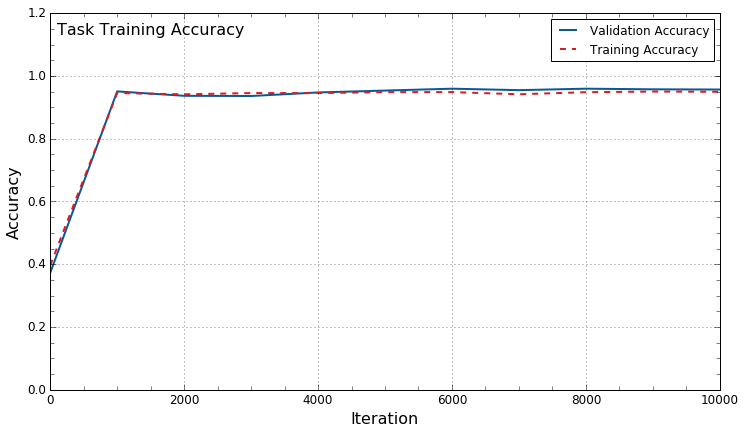

In [37]:
# Colours
col_pink   = '#E13375'
col_blue   = '#095998'
col_orange = '#F17B18'
col_green  = '#29C78D'

col_red    = '#d91c22'
col_cyan   = '#1cd9cc'
col_green  = '#81d91c'

# Set figure size
fig, ax = plt.subplots(figsize=(12,6.75))

# Plotting multiple lines
ax.plot(it_fc100, va_acc_fc100, linewidth=2, color=col_blue, label='Validation Accuracy')
ax.plot(it_fc100, tr_acc_fc100, '--', linewidth=2, color=col_red, label='Training Accuracy')

# Plot title
ax.set_title('Task Training Accuracy', y=0.93, x=0.15, fontsize=16)

# Axes labels, fontsize (offset by adding y=0.0 etc to arguments)
ax.set_ylabel('Accuracy', fontsize=16)
ax.set_xlabel('Iteration', fontsize=16)

# Ticks
ax.minorticks_on()
ax.tick_params(axis='both', which='major', right='on', top='on', direction='in', labelsize=12, length=6)
ax.tick_params(axis='both', which='minor', right='on', top='on', direction='in', labelsize=12, length=4)

# Set range limit on axes
ax.set_ylim([0,1.2])
ax.set_xlim([0,10000])

# To set a grid
ax.grid(True)

# Legend, generated from plot details and labels
ax.legend(loc=1, prop={'size': 12})

# plt.savefig('./experiment/' + the_date + '-' + plotname1 + '.png', bbox_inches='tight')

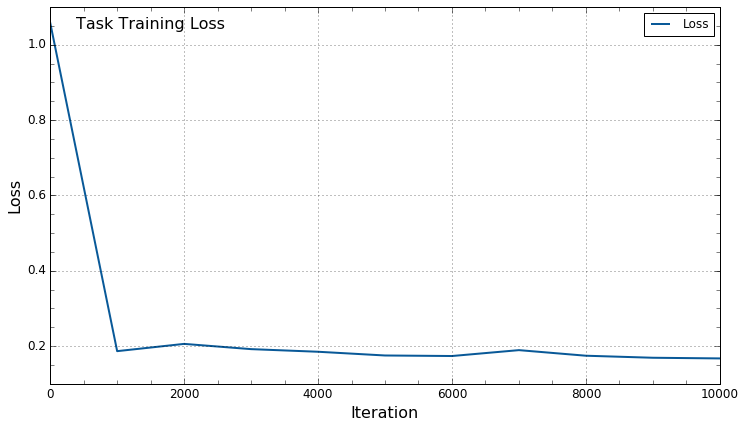

In [39]:
# Set figure size
fig, ax = plt.subplots(figsize=(12,6.75))

ax.plot(it_fc100, loss_fc100, linewidth=2, color=col_blue, label='Loss')

# Plot title
ax.set_title('Task Training Loss', y=0.93, x=0.15, fontsize=16)

# Axes labels, fontsize (offset by adding y=0.0 etc to arguments)
ax.set_ylabel('Loss', fontsize=16)
ax.set_xlabel('Iteration', fontsize=16)

# Ticks
ax.minorticks_on()
ax.tick_params(axis='both', which='major', right='on', top='on', direction='in', labelsize=12, length=6)
ax.tick_params(axis='both', which='minor', right='on', top='on', direction='in', labelsize=12, length=4)

# Set range limit on axes
# ax.set_ylim([0,1.2])
ax.set_xlim([0,10000])

# To set a grid
ax.grid(True)

# Legend, generated from plot details and labels
ax.legend(loc=1, prop={'size': 12})

# plt.savefig('./experiment/' + the_date + '-' + plotname2 + '.png', bbox_inches='tight')